C：   
相当于逻辑回归中的正则化参数的影响。C设置的比较大的时候，SVC可能会选择边界较小的，能够更好地分类所有训练点的  决策边界。如果C设定的较小，SVC会最大化边界，尽量将掉落在决策边界另一方的样本点分类正确。决策功能会更简单，但是训练的精确度会更低。此时，会有更多的红色点会被误分类。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

创建样本不均衡点

In [3]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0],[2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5,0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X,y = make_blobs(n_samples=[class_1,class_2],
              centers=centers,
              cluster_std=clusters_std,
              random_state=0,shuffle=False) #看看数据集长什么样

In [9]:
X.shape

(550, 2)

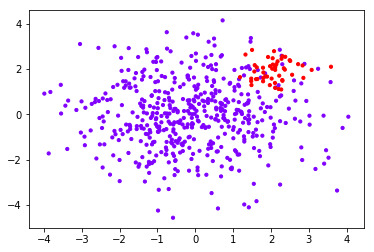

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10) #其中红色点是少数类，紫色点是多数类
plt.show()

在数据集上分别建模

In [4]:
#不设定class_weight
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y) #设定class_weight

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [6]:
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y) #给两个模型分别打分看看，这个分数是accuracy准确度

SVC(C=1.0, cache_size=200, class_weight={1: 10}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [13]:
# 做样本均衡之后，我们的准确率下降了， 未进行样本均衡的准确率更高。
clf.score(X,y)

0.9418181818181818

In [14]:
wclf.score(X,y)

0.9127272727272727

绘制两个模型下数据的决策边界

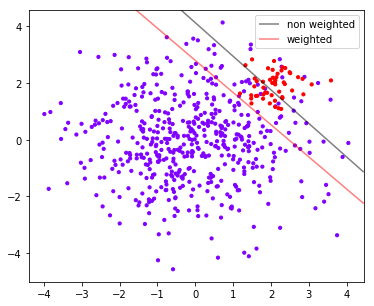

In [18]:
#首先要有数据分布
plt.figure(figsize=(6,5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10)
ax = plt.gca() #获取当前的子图，如果不存在，则创建新的子图

#绘制决策边界的第一步：要有网格
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

#第二步：找出我们的样本点到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape) 
a = ax.contour(XX, YY, Z_clf, colors='black', levels=[0], alpha=0.5, linestyles=['-'])
Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf, colors='red', levels=[0], alpha=0.5, linestyles=['-'])

#第三步：画图例
plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
       loc="upper right")
plt.show()

In [19]:
a.collections #调用这个等高线对象中画的所有线，返回一个惰性对象

<a list of 1 mcoll.LineCollection objects>

In [20]:
#用[*]把它打开试试看
[*a.collections] #返回了一个linecollection对象，其实就是我们等高线里所有的线的列表

In [21]:
#现在我们只有一条线，所以我们可以使用索引0来锁定这个对象
a.collections[0]

In [22]:
#plt.legend([对象列表],[图例列表],loc)
#只要对象列表和图例列表相对应，就可以显示出图例。

SVC模型的评估指标

为了寻找捕获少数类的能力和将多数类判错后需要付出的成本的平衡，引入指标：混淆矩阵和ROC曲线

混淆矩阵是二分类问题的多维衡量指标，在样本不平衡是极其有用。

Precision

In [27]:
#所有判断正确并确实为1的样本 / 所有被判断为1的样本
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(clf.predict(X) == 1).sum()

0.7142857142857143

In [26]:
(y[y == clf.predict(X)] == 1).sum() # 真实值等于预测值得全部点

30

In [28]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(wclf.predict(X) == 1).sum()

0.5102040816326531

Recall

In [29]:
#所有predict为1的点 / 全部为1的点的比例
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(y == 1).sum()

0.6

In [30]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(y == 1).sum()

1.0

召回率和精确度是此消彼长的，两者之间的平衡代表了捕捉少数类的需求和尽量不要误伤多数类的需求平衡。   
具体偏向哪一方，取决于我们的业务需求：究竟数误伤多数类的成本更高还是无法捕捉少数类的代价更高。  
为了兼顾召回率和精确度，创造了两者的调和平均数作为综合性指标，F1-measure.   
两个数之间的调和平均倾向于靠近两个数中比较小的那一个数，因此，我们追求尽量高的F1-measure,   
能够保证精确度和召回率都比较高。它是[0,1]分布，越接近1越好。

In [7]:
#所有被正确预测为0的样本 / 所有的0样本
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 0).sum()/(y == 0).sum()

0.976

In [8]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 0).sum()/(y == 0).sum()

0.904

metrics.{confusion_matrix;   
      accuracy_score;   
      precision_score;   
      recall_score;   
      precision_recall_curve;   
      f1_score}   

使用Recall和FPR之间的平衡，来代替Recall和Precision之间的平衡，让我们衡量模型在尽量捕捉少数类的时候，误伤   
多数类的情况如何变化，引出ROC曲线：   
     ROC--受试者操作特性曲线，以不同阈值下的FPR为横坐标，Recall为纵坐标的曲线。

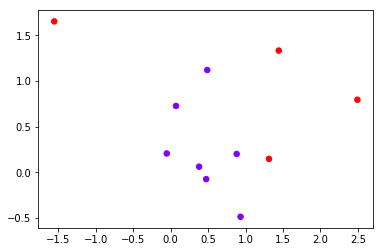

In [12]:
class_1_ = 7
class_2_ = 4
centers_ = [[0.0, 0.0], [1,1]]
clusters_std = [0.5, 1]
X_, y_ = make_blobs(n_samples=[class_1_, class_2_],
              centers=centers_,
              cluster_std=clusters_std,
              random_state=0, shuffle=False)
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap="rainbow",s=30)
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression as LogiR

In [14]:
clf_lo = LogiR().fit(X_,y_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
prob = clf_lo.predict_proba(X_) #将样本和概率放到一个DataFrame中

In [17]:
prob.shape

(11, 2)

In [18]:
import pandas as pd
prob = pd.DataFrame(prob)

In [19]:
prob.columns = ["0","1"]

In [23]:
prob

,0,1,pred
0,0.604664,0.395336,0.0
1,0.458916,0.541084,1.0
2,0.717986,0.282014,0.0
3,0.679109,0.320891,0.0
4,0.664739,0.335261,0.0
5,0.562775,0.437225,0.0
6,0.662054,0.337946,0.0
7,0.355167,0.644833,1.0
8,0.381606,0.618394,1.0
9,0.585284,0.414716,0.0


In [22]:
#手动调节阈值，来改变我们的模型效果
for i in range(prob.shape[0]):
    if prob.loc[i,"1"] > 0.5:
        prob.loc[i,"pred"] = 1
    else:
        prob.loc[i,"pred"] = 0

In [24]:
prob["y_true"] = y_

In [25]:
prob = prob.sort_values(by="1",ascending=False)

In [26]:
prob

,0,1,pred,y_true
7,0.355167,0.644833,1.0,1
8,0.381606,0.618394,1.0,1
1,0.458916,0.541084,1.0,0
10,0.501493,0.498507,0.0,1
5,0.562775,0.437225,0.0,0
9,0.585284,0.414716,0.0,1
0,0.604664,0.395336,0.0,0
6,0.662054,0.337946,0.0,0
4,0.664739,0.335261,0.0,0
3,0.679109,0.320891,0.0,0


In [27]:
from sklearn.metrics import confusion_matrix as CM, precision_score as P, recall_score as R

In [28]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])  # labels 中少数类放在前面

array([[2, 2],
       [1, 6]], dtype=int64)

In [29]:
#试试看手动计算Precision和Recall?

In [30]:
2/3

0.6666666666666666

In [32]:
2/4

0.5

In [33]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])  # 真实值--预测值

0.6666666666666666

In [34]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.5

In [35]:
for i in range(prob.shape[0]):
    if prob.loc[i,"1"] > 0.4:
        prob.loc[i,"pred"] = 1
    else:
        prob.loc[i,"pred"] = 0

In [36]:
prob

,0,1,pred,y_true
7,0.355167,0.644833,1.0,1
8,0.381606,0.618394,1.0,1
1,0.458916,0.541084,1.0,0
10,0.501493,0.498507,1.0,1
5,0.562775,0.437225,1.0,0
9,0.585284,0.414716,1.0,1
0,0.604664,0.395336,0.0,0
6,0.662054,0.337946,0.0,0
4,0.664739,0.335261,0.0,0
3,0.679109,0.320891,0.0,0


In [37]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

array([[4, 0],
       [2, 5]], dtype=int64)

In [38]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.6666666666666666

In [39]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
#注意，降低或者升高阈值并不一定能够让模型的效果变好，一切都基于我们要追求怎样的模型效果
# 通常来说降低阈值可以升高Recall

1.0

参数probability:默认False，设为True时启动，SVC的接口predict_proba和predict_log_proba将生效。   
fit之前启用它，SVC将使用Platt强行将decision_function压缩到Sigmoid,并附加训练数据的交叉验证，   
生成类逻辑回归的SVC分数。

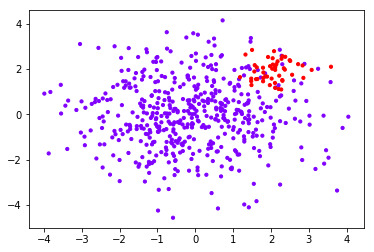

In [6]:
#使用最初的X和y，样本不均衡的这个模型
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
              centers=centers,
              cluster_std=clusters_std,
              random_state=0, shuffle=False) #看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10) #其中红色点是少数类，紫色点是多数类
plt.show()

In [7]:
clf_proba = svm.SVC(kernel="linear",C=1.0,probability=True).fit(X,y)

In [43]:
clf_proba.predict_proba(X)

array([[0.68620027, 0.31379973],
       [0.26690884, 0.73309116],
       [0.96163087, 0.03836913],
       ...,
       [0.15925407, 0.84074593],
       [0.35631697, 0.64368303],
       [0.31938555, 0.68061445]])

In [44]:
clf_proba.predict_proba(X).shape  # 生成的各类样本对应下的概率

(550, 2)

In [45]:
clf_proba.decision_function(X)

array([ -0.39182241,   0.95617053,  -2.24996184,  -2.63659269,
        -3.65243197,  -1.67311996,  -2.56396417,  -2.80650393,
        -1.76184723,  -4.7948575 ,  -7.59061196,  -3.66174848,
        -2.2508023 ,  -4.27626526,   0.78571364,  -3.24751892,
        -8.57016271,  -4.45823747,  -0.14034183,  -5.20657114,
        -8.02181046,  -4.18420871,  -5.6222409 ,  -5.12602771,
        -7.22592707,  -5.07749638,  -6.72386021,  -3.4945225 ,
        -3.51475144,  -5.72941551,  -5.79160724,  -8.06232013,
        -4.36303857,  -6.25419679,  -5.59426696,  -2.60919281,
        -3.90887478,  -4.38754704,  -6.46432224,  -4.54279979,
        -4.78961735,  -5.53727469,   1.33920817,  -2.27766451,
        -4.39650854,  -2.97649872,  -2.26771979,  -2.40781748,
        -1.41638181,  -3.26142275,  -2.7712218 ,  -4.87288439,
        -3.2594128 ,  -5.91189118,   1.48676267,   0.5389064 ,
        -2.76188843,  -3.36126945,  -2.64697843,  -1.63635284,
        -5.04695135,  -1.59196902,  -5.5195418 ,  -2.10

In [47]:
clf_proba.decision_function(X).shape

(550,)

绘制ROC曲线

In [48]:
#首先来看看如何从混淆矩阵中获取FPR和Recall
cm = CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
cm

array([[4, 0],
       [2, 5]], dtype=int64)

In [49]:
#FPR   被预测错误的0占所有真正为0的样本的比例
cm[1,0]/cm[1,:].sum()

0.2857142857142857

In [50]:
#Recall
cm[0,0]/cm[0,:].sum()

1.0

In [51]:
# 概率 clf_proba.predict_proba(X)[:,1] # 我的类别1下面的概率

In [52]:
# 阈值，每一个阈值都对应这一次循环，每一次循环，都要有一个混淆矩阵，要有一组假正率vsRecall

In [ ]:
# np.lispace(概率最小值，概率最大值，55，endpoint=False) # 可以取到我的最大值
# if i > 概率最大值，返回1
# endpoint=False  请不要给我取到最大值

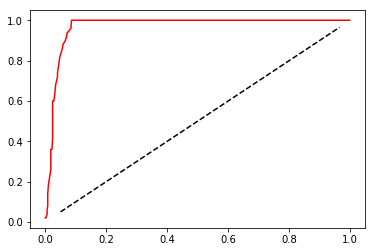

In [53]:
#开始绘图
probrange = np.linspace(clf_proba.predict_proba(X)[:,1].min()
                        ,clf_proba.predict_proba(X)[:,1].max()
                        ,num=50,endpoint=False)
from sklearn.metrics import confusion_matrix as CM, recall_score as R
import matplotlib.pyplot as plot

recall = []
FPR = []

for i in probrange:
    y_predict = []
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j,1] > i:
            y_predict.append(1)
        else:
            y_predict.append(0)
    cm = CM(y,y_predict,labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())
    
recall.sort()
FPR.sort()

plt.plot(FPR,recall,c="red")
plt.plot(probrange+0.05,probrange+0.05,c="black",linestyle="--")
plt.show()

我们希望看到的图像是纵坐标极速上升，横坐标缓慢增长，聚集在左上方的图像。

ROC曲线如果是凹的，越接近右下方越好，越接近中间黑线模型越糟糕

在sklearn中，我们有帮助我们计算ROC曲线的横坐标---假正率FPR、纵坐标Recall、对应的阈值---的类   
sklearn.metrics.roc_curve。同时，我们还有帮助我们计算AUC面积的类sklearn.metrics.roc_auc_score。

sklearn.metrics.roc_curve(y_ture(真实标签），y_score(置信度分数),pos_label(正类类别),sample_weight(样本权重），drop_intermediate(默认True，会舍弃一些)

In [1]:
from sklearn.metrics import roc_curve

In [8]:
FPR, recall, thresholds = roc_curve(y,clf_proba.decision_function(X), pos_label=1)

In [9]:
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [10]:
recall

array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [11]:
thresholds #此时的threshold就不是一个概率值，而是距离值中的阈值了，所以它可以大于1,也可以为负。

array([  3.18236076,   2.18236076,   1.48676267,   1.35964325,
         1.33920817,   1.14038015,   1.13383091,   1.00003406,
         0.85085628,   0.84476439,   0.78571364,   0.60568093,
         0.5389064 ,   0.46718521,   0.44396046,   0.03907036,
        -0.07011269,  -0.10668727,  -0.1258212 ,  -0.13845693,
        -0.14034183,  -0.16790648,  -0.2040958 ,  -0.22137683,
        -0.24381463,  -0.26762451,  -0.34446784,  -0.3467975 ,
        -0.39182241,  -0.40676459,  -0.4589064 ,  -0.46310299,
        -0.49195707,  -0.5088941 ,  -0.53560561,  -0.55152081,
        -0.62628865,  -0.67580418,  -0.78127198,  -0.79874442,
        -0.88438995,  -0.91257798,  -1.01417607,  -1.08601917,
       -10.31959605])

In [12]:
from sklearn.metrics import roc_auc_score as AUC
area = AUC(y,clf_proba.decision_function(X))

In [13]:
area

0.9696400000000001

In [20]:
plt.figure()
plt.plot(FPR, recall, color='red',
       label="ROC curve (area = %0.2f)"% area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-20-362766230e81>, line 3)

In [21]:
max((recall - FPR).tolist())

0.914

In [22]:
maxindex = (recall - FPR).tolist().index(max(recall - FPR))

In [23]:
maxindex

43

In [24]:
thresholds[maxindex] #我们可以在图像上来看看这个点在哪里

-1.0860191749391461

In [ ]:
plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30) 

In [25]:
#把上述代码放入这段代码中：
plt.figure()
plt.plot(FPR, recall, color='red',
      label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-25-a03f1e1cf365>, line 4)

案例：预测明天是否会下雨

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
weather = pd.read_csv(r"D:\titanic\weather.csv",index_col=0)

In [3]:
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7,No
1,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3,No
2,2010-02-08,Adelaide,24.0,38.1,0.0,23.4,13.0,SE,39.0,NNE,...,19.0,36.0,24.0,1018.0,1016.0,NaN,NaN,32.4,37.4,No
3,2016-09-19,Adelaide,6.7,16.4,0.4,NaN,NaN,N,31.0,N,...,15.0,65.0,40.0,1014.4,1010.0,NaN,NaN,11.2,15.9,No
4,2014-03-05,Adelaide,16.7,24.8,0.0,6.6,11.7,S,37.0,S,...,24.0,61.0,48.0,1019.3,1018.9,NaN,NaN,20.8,23.7,No


In [4]:
#将特征矩阵和标签Y分开
X = weather.iloc[:,:-1] 
Y = weather.iloc[:,-1] 

In [5]:
X.shape

(5000, 21)

In [6]:
# 分裂快捷键：ctrl shift -
# 合并快捷键：shift M

In [7]:
#探索数据类型
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
Date             5000 non-null object
Location         5000 non-null object
MinTemp          4979 non-null float64
MaxTemp          4987 non-null float64
Rainfall         4950 non-null float64
Evaporation      2841 non-null float64
Sunshine         2571 non-null float64
WindGustDir      4669 non-null object
WindGustSpeed    4669 non-null float64
WindDir9am       4651 non-null object
WindDir3pm       4887 non-null object
WindSpeed9am     4949 non-null float64
WindSpeed3pm     4919 non-null float64
Humidity9am      4936 non-null float64
Humidity3pm      4880 non-null float64
Pressure9am      4506 non-null float64
Pressure3pm      4504 non-null float64
Cloud9am         3111 non-null float64
Cloud3pm         3012 non-null float64
Temp9am          4967 non-null float64
Temp3pm          4912 non-null float64
dtypes: float64(16), object(5)
memory usage: 859.4+ KB


In [8]:
#探索缺失值
X.isnull().mean()  # isnull().sum()/X.shape[0]
# 要有不同的缺失值填补策略

Date             0.0000
Location         0.0000
MinTemp          0.0042
MaxTemp          0.0026
Rainfall         0.0100
Evaporation      0.4318
Sunshine         0.4858
WindGustDir      0.0662
WindGustSpeed    0.0662
WindDir9am       0.0698
WindDir3pm       0.0226
WindSpeed9am     0.0102
WindSpeed3pm     0.0162
Humidity9am      0.0128
Humidity3pm      0.0240
Pressure9am      0.0988
Pressure3pm      0.0992
Cloud9am         0.3778
Cloud3pm         0.3976
Temp9am          0.0066
Temp3pm          0.0176
dtype: float64

In [9]:
# Esc a enter  -------快捷键
# 操作模式，编辑模式
# Esc b enter  -------下面加
# Esc dd  ---------删除

In [10]:
Y.shape

(5000,)

In [11]:
Y.isnull().sum() # 加和的时候，True是1，False是0

0

In [12]:
#探索标签的分类
np.unique(Y)  # 说明标签是二分类

array(['No', 'Yes'], dtype=object)

In [13]:
#分训练集和测试集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.3,random_state=420)   # 随机抽样

In [14]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
1809,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
4176,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,7.0,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6
110,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,17.0,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8
3582,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,11.0,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5
2162,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4


In [15]:
#恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

In [16]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,17.0,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,7.0,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,17.0,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,11.0,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4


In [17]:
Ytrain.head()

0     No
1     No
2     No
3    Yes
4     No
Name: RainTomorrow, dtype: object

In [18]:
#是否有样本不平衡问题？
Ytrain.value_counts()

No     2704
Yes     796
Name: RainTomorrow, dtype: int64

In [19]:
Ytest.value_counts()

No     1157
Yes     343
Name: RainTomorrow, dtype: int64

In [65]:
# 有轻微的样本不均衡问题

In [20]:
Ytrain.value_counts()[0]/Ytrain.value_counts()[1]

3.3969849246231156

In [67]:
#将标签编码
from sklearn.preprocessing import LabelEncoder  # 标签专用，第三章讲过。
encorder = LabelEncoder().fit(Ytrain)  # 允许一维数据输入的

In [68]:
#  使用训练集进行训练，然后在训练集合测试集上分别进行transform
Ytrain = pd.DataFrame(encorder.transform(Ytrain))
Ytest = pd.DataFrame(encorder.transform(Ytest))

# 如果我们的测试集中，出现了训练集中没有出现过的标签类别，
# 比如说，测试集中有YES,NO,UNKOWN
# 而我们的训练集中只有YES和NO

In [69]:
Ytrain

,0
0,0
1,0
2,0
3,1
4,0
5,0
6,0
7,0
8,0
9,1


In [71]:
Ytest.head()

,0
0,0
1,0
2,1
3,0
4,0


In [72]:
# Ytrain.to_csv("你想要保存这个文件的地址.文件名.csv")

In [73]:
#描述性统计
Xtrain.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
MinTemp,3486.0,12.225645,6.396243,-6.5,-1.715,1.800,4.1,7.7,12.0,16.7,20.9,25.900,29.0
MaxTemp,3489.0,23.245543,7.201839,-3.7,8.888,12.840,14.5,18.0,22.5,28.4,33.0,40.400,46.4
Rainfall,3467.0,2.487049,7.949686,0.0,0.000,0.000,0.0,0.0,0.0,0.8,6.6,41.272,115.8
Evaporation,1983.0,5.619163,4.383098,0.0,0.400,0.800,1.4,2.6,4.8,7.4,10.2,20.600,56.0
Sunshine,1790.0,7.508659,3.805841,0.0,0.000,0.345,1.4,4.6,8.3,10.6,12.0,13.300,13.9
WindGustSpeed,3263.0,39.858413,13.219607,9.0,15.000,20.000,24.0,31.0,39.0,48.0,57.0,76.000,117.0
WindSpeed9am,3466.0,14.046163,8.670472,0.0,0.000,0.000,4.0,7.0,13.0,19.0,26.0,37.000,65.0
WindSpeed3pm,3437.0,18.553390,8.611818,0.0,2.000,6.000,7.0,13.0,19.0,24.0,30.0,43.000,65.0
Humidity9am,3459.0,69.069095,18.787698,2.0,18.000,35.000,45.0,57.0,70.0,83.0,94.0,100.000,100.0
Humidity3pm,3408.0,51.651995,20.697872,2.0,9.000,17.000,23.0,37.0,52.0,66.0,79.0,98.000,100.0


In [74]:
Xtest.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
MinTemp,1493.0,11.916812,6.375377,-8.5,-2.024,1.600,3.70,7.3,11.8,16.5,20.48,25.316,28.3
MaxTemp,1498.0,22.906809,6.986043,-0.8,9.134,13.000,14.50,17.8,22.4,27.8,32.60,38.303,45.1
Rainfall,1483.0,2.241807,7.988822,0.0,0.000,0.000,0.00,0.0,0.0,0.8,5.20,35.372,108.2
Evaporation,858.0,5.657809,4.105762,0.0,0.400,1.000,1.60,2.8,4.8,7.6,10.40,19.458,38.8
Sunshine,781.0,7.677465,3.862294,0.0,0.000,0.300,1.50,4.7,8.6,10.7,12.20,13.400,13.9
WindGustSpeed,1406.0,40.044097,14.027052,9.0,15.000,20.000,24.00,30.0,39.0,48.0,57.00,78.000,122.0
WindSpeed9am,1483.0,13.986514,9.124337,0.0,0.000,0.000,4.00,7.0,13.0,20.0,26.00,39.360,72.0
WindSpeed3pm,1482.0,18.601215,8.850446,0.0,2.000,6.000,7.00,13.0,19.0,24.0,31.00,43.000,56.0
Humidity9am,1477.0,68.688558,18.876448,4.0,20.000,36.000,44.00,57.0,69.0,82.0,95.00,100.000,100.0
Humidity3pm,1472.0,51.431386,20.459957,2.0,8.710,18.000,23.00,37.0,52.0,66.0,78.00,96.290,100.0


In [75]:
# 对于去kaggle上下载了数据的小伙伴们，以及对于坚持要使用完整版数据的（15w）数据的小伙伴们
# 如果发现了异常值，首先你要观察，这个异常值出现的频率
# 如果异常值只出现了一次吗，多半是输入错误，直接把异常值删除
# 如果异常值出现了多次，去跟业务人员沟通，认为造成的错误异常值留着是没有用的。
# 但是如果异常值占总数据的百分之十左右，把异常值替换成非异常但是非干扰项，或者把异常当缺失，均值或众数填补。

In [77]:
# """
# 对于去kaggle上下载了数据的小伙伴们，以及坚持要使用完整版数据的（15W行）小伙伴们
# 如果你发现了异常值，首先你要观察，这个异常值出现的频率
# 如果异常值只出现了一次，多半是输入错误，直接把异常值删除
# 如果异常值出现了多次，去跟业务人员沟通，可能这是某种特殊表示，如果是人为造成的错误，异常值留着是没有用
# 的，只要数据量不是太大，都可以删除
# 如果异常值占到你总数据量的10%以上了，不能轻易删除。可以考虑把异常值替换成非异常但是非干扰的项，比如说用0
# 来进行替换，或者把异常当缺失值，用均值或者众数来进行替换
# """

In [78]:
#先查看原始的数据结构
Xtrain.shape
Xtest.shape
#观察异常值是大量存在，还是少数存在
Xtrain.loc[Xtrain.loc[:,"Cloud9am"] == 9,"Cloud9am"]
Xtest.loc[Xtest.loc[:,"Cloud9am"] == 9,"Cloud9am"]
Xtest.loc[Xtest.loc[:,"Cloud3pm"] == 9,"Cloud3pm"] #少数存在，于是采取删除的策略
#注意如果删除特征矩阵，则必须连对应的标签一起删除，特征矩阵的行和标签的行必须要一一对应
Xtrain = Xtrain.drop(index = 71737)
Ytrain = Ytrain.drop(index = 71737) #删除完毕之后，观察原始的数据结构，确认删除正确
Xtrain.shape
Xtest = Xtest.drop(index = [19646,29632])
Ytest = Ytest.drop(index = [19646,29632])
Xtest.shape
#进行任何行删除之后，千万记得要恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])
Xtrain.head()
Xtest.head()

KeyError: '[71737] not found in axis'

In [79]:
Xtrainc = Xtrain.copy()

In [80]:
Xtrainc.sort_values(by="Location")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
2796,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,13.0,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7
2975,2012-08-17,Adelaide,7.8,13.2,17.6,0.8,NaN,SW,61.0,SW,...,20.0,28.0,76.0,47.0,1012.5,1014.7,NaN,NaN,8.3,12.5
775,2013-03-16,Adelaide,17.4,23.8,NaN,NaN,9.7,SSE,46.0,S,...,9.0,19.0,63.0,57.0,1019.9,1020.5,NaN,NaN,19.1,20.7
861,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3
2906,2015-08-24,Adelaide,9.2,14.3,0.0,NaN,NaN,SE,48.0,SE,...,17.0,19.0,64.0,42.0,1024.7,1024.1,NaN,NaN,9.9,13.4
2900,2009-09-17,Adelaide,14.2,17.4,8.8,2.0,7.1,SW,41.0,SSW,...,15.0,20.0,82.0,56.0,1014.9,1018.0,NaN,NaN,16.2,16.7
902,2008-12-10,Adelaide,14.2,28.0,0.0,6.4,12.5,SE,48.0,E,...,13.0,13.0,56.0,35.0,1010.8,1008.9,NaN,NaN,19.3,25.6
919,2011-10-12,Adelaide,7.7,19.9,0.0,3.4,11.4,W,30.0,E,...,13.0,15.0,56.0,43.0,1021.2,1018.1,NaN,NaN,14.1,19.4
936,2014-03-11,Adelaide,22.3,32.2,0.4,20.6,3.2,W,65.0,ESE,...,9.0,9.0,53.0,78.0,1017.0,1017.2,NaN,NaN,25.6,22.8
942,2015-02-23,Adelaide,20.6,26.5,0.0,16.2,NaN,SSE,48.0,S,...,20.0,22.0,61.0,43.0,1015.3,1016.5,NaN,NaN,22.2,25.7


In [81]:
Xtrain.iloc[:,0].value_counts()

2015-07-03    6
2015-10-12    6
2014-05-16    6
2013-12-20    5
2012-11-23    5
2014-07-26    5
2016-09-07    5
2009-07-17    5
2011-07-19    5
2010-05-18    5
2012-07-18    5
2011-09-04    5
2010-11-03    5
2016-11-01    5
2014-03-12    5
2014-02-12    5
2014-06-16    5
2009-06-29    5
2012-09-18    5
2017-01-09    5
2009-03-30    5
2011-11-04    5
2012-03-26    4
2013-11-08    4
2015-07-18    4
2011-07-04    4
2011-01-17    4
2015-11-15    4
2012-04-19    4
2015-05-17    4
             ..
2010-06-03    1
2016-10-13    1
2010-05-14    1
2009-04-22    1
2012-06-26    1
2015-08-10    1
2016-04-18    1
2009-03-15    1
2010-06-22    1
2012-01-29    1
2017-06-23    1
2014-08-07    1
2008-05-07    1
2016-04-07    1
2017-04-08    1
2011-05-01    1
2013-04-05    1
2011-01-29    1
2013-10-06    1
2010-06-07    1
2017-02-22    1
2015-01-08    1
2013-05-11    1
2013-07-13    1
2011-10-16    1
2015-04-24    1
2017-04-28    1
2011-08-02    1
2017-02-01    1
2014-12-09    1
Name: Date, Length: 2141

In [ ]:
#首先，日期不是独一无二的，日期有重复
#其次，在我们分训练集和测试集之后，日期也不是连续的，而是分散的
#某一年的某一天倾向于会下雨？或者倾向于不会下雨吗？
#不是日期影响了下雨与否，反而更多的是这一天的日照时间，湿度，温度等等这些因素影响了是否会下雨
#光看日期，其实感觉它对我们的判断并无直接影响
#如果我们把它当作连续型变量处理，那算法会人为它是一系列1~3000左右的数字，不会意识到这是日期

In [82]:
Xtrain.iloc[:,0].value_counts().count()
#如果我们把它当作分类型变量处理，类别太多，有2141类，如果换成数值型，会被直接当成连续型变量，如果做成哑
# 变量，我们特征的维度会爆炸

2141

In [ ]:
Xtrain = Xtrain.drop(["Date"],axis=1)
Xtest = Xtest.drop(["Date"],axis=1)

In [21]:
Xtrain["Rainfall"].head(20)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.2
8      0.0
9      0.2
10     1.0
11     0.0
12     0.2
13     0.0
14     0.0
15     3.0
16     0.2
17     0.0
18    35.2
19     0.0
Name: Rainfall, dtype: float64

In [22]:
Xtrain["Rainfall"].isnull().sum()
# 假设你没有下雨
# 复制你的空值

33

In [23]:
Xtrain.loc[Xtrain["Rainfall"] >= 1,"RainToday"] = "Yes"
Xtrain.loc[Xtrain["Rainfall"] < 1,"RainToday"] = "No"
Xtrain.loc[Xtrain["Rainfall"] == np.nan,"RainToday"] = np.nan

# 报的是警告

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [25]:
Xtest.loc[Xtest["Rainfall"] >= 1,"RainToday"] = "Yes"
Xtest.loc[Xtest["Rainfall"] < 1,"RainToday"] = "No"
Xtest.loc[Xtest["Rainfall"] == np.nan,"RainToday"] = np.nan

In [26]:
Xtrain.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2015-08-24,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,2016-12-10,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,2010-04-18,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,2009-11-26,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,2014-04-25,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [27]:
Xtest.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2016-01-23,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,2009-03-05,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,2010-03-05,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-26,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,2016-11-28,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


In [ ]:
int(Xtrain.loc[0,"Date"].split("-")[1]) #提取出月份

In [28]:
Xtrain["Date"] = Xtrain["Date"].apply(lambda x:int(x.split("-")[1]))
# apply是对dataframe上的某一列进行处理的一个函数
# lambda x匿名函数，请在dataframe上着一列中的每一行帮我执行冒号后的命令
# 用apply代替了循环，更高级的操作。

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
Xtrain.loc[:,"Date"].value_counts()

3     334
5     324
7     316
9     302
6     302
1     300
11    299
10    282
4     265
2     264
12    259
8     253
Name: Date, dtype: int64

In [31]:
#替换完毕后，我们需要修改列的名称
#rename是比较少有的，可以用来修改单个列名的函数
#我们通常都直接使用 df.columns = 某个列表 这样的形式来一次修改所有的列名
#但rename允许我们只修改某个单独的列
Xtrain = Xtrain.rename(columns={"Date":"Month"})

In [32]:
Xtrain.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [33]:
Xtrain.head()
Xtest["Date"] = Xtest["Date"].apply(lambda x:int(x.split("-")[1]))
Xtest = Xtest.rename(columns={"Date":"Month"})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
Xtest.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


首先，我们可以想到，昨天的天气可能会影响今天的天气，而今天的天气又可能会影响明天的天气。也就是说，随
着日期的逐渐改变，样本是会受到上一个样本的影响的。但是对于算法来说，普通的算法是无法捕捉到样本与样本
之间的联系的，我们的算法捕捉的是样本的每个特征与标签之间的联系（即列与列之间的联系），而无法捕捉样本
与样本之间的联系（行与行的联系）。   

要让算法理解上一个样本的标签可能会影响下一个样本的标签，我们必须使用时间序列分析。时间序列分析是指将
同一统计指标的数值按其发生的时间先后顺序排列而成的数列。时间序列分析的主要目的是根据已有的历史数据对
未来进行预测。然而，（据我所知）时间序列只能在单调的，唯一的时间上运行，即一次只能够对一个地点进行预
测，不能够实现一次性预测多个地点，除非进行循环。而我们的时间数据本身，不是单调的，也不是唯一的，经过
抽样之后，甚至连连续的都不是了，我们的时间是每个混杂在多个地点中，每个地点上的一小段时间。如何使用时
间序列来处理这个问题，就会变得复杂。   

那我们可以换一种思路，既然算法处理的是列与列之间的关系，我是否可以把”今天的天气会影响明天的天气“这个
指标转换成一个特征呢？我们就这样来操作。   

我们观察到，我们的特征中有一列叫做“Rainfall"，这是表示当前日期当前地区下的降雨量，换句话说，也就是”今
天的降雨量“。凭常识我们认为，今天是否下雨，应该会影响明天是否下雨，比如有的地方可能就有这样的气候，
一旦下雨就连着下很多天，也有可能有的地方的气候就是一场暴雨来得快去的快。因此，我们可以将时间对气候的
连续影响，转换为”今天是否下雨“这个特征，巧妙地将样本对应标签之间的联系，转换成是特征与标签之间的联系
了。

如此，我们就创造了一个特征，今天是否下雨“RainToday”。   

那现在，我们是否就可以将日期删除了呢？对于我们而言，日期本身并不影响天气，但是日期所在的月份和季节其
实是影响天气的，如果任选梅雨季节的某一天，那明天下雨的可能性必然比非梅雨季节的那一天要大。虽然我们无
法让机器学习体会不同月份是什么季节，但是我们可以对不同月份进行分组，算法可以通过训练感受到，“这个月
或者这个季节更容易下雨”。因此，我们可以将月份或者季节提取出来，作为一个特征使用，而舍弃掉具体的日
期。如此，我们又可以创造第二个特征--Month

特征：地点

In [37]:
Xtrain.loc[:,"Location"].value_counts().count() 
# 超过25个类别的分类型变量，会被算法当成是连续型变量

49

我们的样本中含有49个不同地点，如果做
成分类型变量，算法就无法辨别它究竟是否是分类变量。也就是说，我们需要让算法意识到，不同的地点因为气候
不同，所以对“明天是否会下雨”有着不同的影响。如果我们能够将地点转换为这个地方的气候的话，我们就可以将
不同城市打包到同一个气候中，而同一个气候下反应的降雨情况应该是相似的。

我使用以下代码，在google上进行爬虫，爬出了每
个城市所对应的经纬度

In [48]:
cityll = pd.read_csv(r"D:\titanic\cityll.csv",index_col=0)

In [44]:
city_climate = pd.read_csv(r"D:\titanic\cityclimate.csv")

In [56]:
cityll.head()  # 每个城市对应的经纬度，这些城市是澳大利亚统计局做的那张地图上的城市

,City,Latitude,Longitude,Latitudedir,Longitudedir,Latitudenum,Longitudenum
0,Adelaide,34.9285°,138.6007°,"S,",E,34.9285,138.6007
1,Albany,35.0275°,117.8840°,"S,",E,35.0275,117.8840
2,Albury,36.0737°,146.9135°,"S,",E,36.0737,146.9135
3,Wodonga,36.1241°,146.8818°,"S,",E,36.1241,146.8818
4,AliceSprings,23.6980°,133.8807°,"S,",E,23.6980,133.8807


In [50]:
city_climate.head()  # 澳大利亚统计局做的每个城市对应的气候

,City,Climate
0,Adelaide,Warm temperate
1,Albany,Mild temperate
2,Albury,"Hot dry summer, cool winter"
3,Wodonga,"Hot dry summer, cool winter"
4,AliceSprings,"Hot dry summer, warm winter"


In [54]:
float(cityll.loc[0,"Latitude"][:-1])

34.9285

In [57]:
cityll.loc[:,"Latitudedir"].value_counts()

S,    100
Name: Latitudedir, dtype: int64

In [55]:
#去掉度数符号
cityll["Latitudenum"] = cityll["Latitude"].apply(lambda x:float(x[:-1]))
cityll["Longitudenum"] = cityll["Longitude"].apply(lambda x:float(x[:-1]))

In [58]:
#观察一下所有的经纬度方向都是一致的，全部是南纬，东经，因为澳大利亚在南半球，东半球
#所以经纬度的方向我们可以舍弃了
citylld = cityll.iloc[:,[0,5,6]]

In [60]:
citylld.head()

,City,Latitudenum,Longitudenum
0,Adelaide,34.9285,138.6007
1,Albany,35.0275,117.8840
2,Albury,36.0737,146.9135
3,Wodonga,36.1241,146.8818
4,AliceSprings,23.6980,133.8807


In [61]:
#将city_climate中的气候添加到我们的citylld中
citylld["climate"] = city_climate.iloc[:,-1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
citylld.head()

,City,Latitudenum,Longitudenum,climate
0,Adelaide,34.9285,138.6007,Warm temperate
1,Albany,35.0275,117.8840,Mild temperate
2,Albury,36.0737,146.9135,"Hot dry summer, cool winter"
3,Wodonga,36.1241,146.8818,"Hot dry summer, cool winter"
4,AliceSprings,23.6980,133.8807,"Hot dry summer, warm winter"


In [63]:
citylld.loc[:,"climate"].value_counts()

Hot dry summer, cool winter          24
Hot dry summer, warm winter          18
Warm temperate                       18
High humidity summer, warm winter    17
Cool temperate                        9
Mild temperate                        9
Warm humid summer, mild winter        5
Name: climate, dtype: int64

接下来继续爬虫：   
   样本点上的气象站到这些城市的经纬度距离。

略

In [68]:
samplecity = pd.read_csv(r"D:\titanic\samplecity.csv",index_col=0)

In [69]:
samplecity.head()

,City,Latitude,Longitude,Latitudedir,Longitudedir
0,Canberra,35.2809°,149.1300°,"S,",E
1,Sydney,33.8688°,151.2093°,"S,",E
2,Perth,31.9505°,115.8605°,"S,",E
3,Darwin,12.4634°,130.8456°,"S,",E
4,Hobart,42.8821°,147.3272°,"S,",E


In [71]:
#我们对samplecity也执行同样的处理：去掉经纬度中度数的符号，并且舍弃我们的经纬度的方向
samplecity["Latitudenum"] = samplecity["Latitude"].apply(lambda x:float(x[:-1]))
samplecity["Longitudenum"] = samplecity["Longitude"].apply(lambda x:float(x[:-1]))
samplecityd = samplecity.iloc[:,[0,5,6]]

In [70]:
samplecityd.head()

,City,Latitudenum,Longitudenum
0,Canberra,35.2809,149.1300
1,Sydney,33.8688,151.2093
2,Perth,31.9505,115.8605
3,Darwin,12.4634,130.8456
4,Hobart,42.8821,147.3272


In [72]:
# 首先使用tadians将角度转换为弧度

from math import radians,sin,cos, acos
citylld.loc[:,"slat"] = citylld.iloc[:,1].apply(lambda x : radians(x))
citylld.loc[:,"slon"] = citylld.iloc[:,2].apply(lambda x : radians(x))

samplecityd.loc[:,"elat"] = samplecityd.iloc[:,1].apply(lambda x : radians(x))
samplecityd.loc[:,"elon"] = samplecityd.iloc[:,2].apply(lambda x : radians(x))

In [73]:
samplecity.head()

,City,Latitude,Longitude,Latitudedir,Longitudedir,Latitudenum,Longitudenum
0,Canberra,35.2809°,149.1300°,"S,",E,35.2809,149.1300
1,Sydney,33.8688°,151.2093°,"S,",E,33.8688,151.2093
2,Perth,31.9505°,115.8605°,"S,",E,31.9505,115.8605
3,Darwin,12.4634°,130.8456°,"S,",E,12.4634,130.8456
4,Hobart,42.8821°,147.3272°,"S,",E,42.8821,147.3272


In [74]:
citylld.head()

,City,Latitudenum,Longitudenum,climate,slat,slon
0,Adelaide,34.9285,138.6007,Warm temperate,0.609617,2.419039
1,Albany,35.0275,117.8840,Mild temperate,0.611345,2.057464
2,Albury,36.0737,146.9135,"Hot dry summer, cool winter",0.629605,2.564124
3,Wodonga,36.1241,146.8818,"Hot dry summer, cool winter",0.630484,2.563571
4,AliceSprings,23.6980,133.8807,"Hot dry summer, warm winter",0.413608,2.336659


In [75]:
import sys
for i in range(samplecityd.shape[0]):
    slat = citylld.loc[:,"slat"]
    slon = citylld.loc[:,"slon"]
    elat = samplecityd.loc[i,"elat"]
    elon = samplecityd.loc[i,"elon"]
    
    dist = 6371.01 * np.arccos(np.sin(slat)*np.sin(elat) +
                          np.cos(slat)*np.cos(elat)*np.cos(slon.values - elon))
    
    city_index = np.argsort(dist)[0]  # 排序并且返回索引
    
    #每次计算后，取距离最近的城市，然后将最近的城市和城市对应的气候都匹配到samplecityd中
    samplecityd.loc[i,"closest_city"] = citylld.loc[city_index,"City"]
    samplecityd.loc[i,"climate"] = citylld.loc[city_index,"climate"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':


In [76]:
#查看最后的结果，需要检查城市匹配是否基本正确
samplecityd.head()

# 据观察，一致的城市是比较一致的，不一致的城市也是比较相似的。

,City,Latitudenum,Longitudenum,elat,elon,closest_city,climate
0,Canberra,35.2809,149.1300,0.615768,2.602810,Canberra,Cool temperate
1,Sydney,33.8688,151.2093,0.591122,2.639100,Sydney,Warm temperate
2,Perth,31.9505,115.8605,0.557641,2.022147,Perth,Warm temperate
3,Darwin,12.4634,130.8456,0.217527,2.283687,Darwin,"High humidity summer, warm winter"
4,Hobart,42.8821,147.3272,0.748434,2.571345,Hobart,Cool temperate


In [77]:
#查看气候的分布
samplecityd["climate"].value_counts()

Warm temperate                       15
Mild temperate                       10
Cool temperate                        9
Hot dry summer, cool winter           6
High humidity summer, warm winter     4
Hot dry summer, warm winter           3
Warm humid summer, mild winter        2
Name: climate, dtype: int64

In [78]:
#确认无误后，取出样本城市所对应的气候，并保存
locafinal = samplecityd.iloc[:,[0,-1]]

In [81]:
locafinal.head()

,Location,Climate
0,Canberra,Cool temperate
1,Sydney,Warm temperate
2,Perth,Warm temperate
3,Darwin,"High humidity summer, warm winter"
4,Hobart,Cool temperate


In [80]:
locafinal.columns = ["Location","Climate"] 

In [82]:
#在这里设定locafinal的索引为地点，是为了之后进行map的匹配
locafinal = locafinal.set_index(keys="Location")

In [84]:
locafinal.head()

,Climate
Location,
Canberra,Cool temperate
Sydney,Warm temperate
Perth,Warm temperate
Darwin,"High humidity summer, warm winter"
Hobart,Cool temperate


In [85]:
locafinal.to_csv(r"D:\titanic\samplelocation.csv")

In [86]:
locafinal.head()

,Climate
Location,
Canberra,Cool temperate
Sydney,Warm temperate
Perth,Warm temperate
Darwin,"High humidity summer, warm winter"
Hobart,Cool temperate


有了每个样本城市所对应的气候，我们接下来就使用气候来替掉原本的城市，原本的气象站的名称。在这里，我们
可以使用map功能，map能够将特征中的值一一对应到我们设定的字典中，并且用字典中的值来替换样本中原本的
值

In [87]:
#是否还记得训练集长什么样呢？
Xtrain.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [89]:
#将location中的内容替换，并且确保匹配进入的气候字符串中不含有逗号，气候两边不含有空格
#我们使用re这个模块来消除逗号
#re.sub(希望替换的值，希望被替换成的值，要操作的字符串)  # 去掉逗号
#x.strip()是去掉空格的函数
# 把location 替换成气候的是我们的map的映射
import re

In [90]:
Xtrain["Location"] = Xtrain["Location"].map(locafinal.iloc[:,0])  # 城市替换成对应的气候
Xtrain["Location"] = Xtrain["Location"].apply(lambda x:re.sub(",","",x.strip())) # 城市的气候中所含的逗号和空格都去掉。

Xtest["Location"] = Xtest["Location"].map(locafinal.iloc[:,0])
Xtest["Location"] = Xtest["Location"].apply(lambda x:re.sub(",","",x.strip()))

# 根据我的索引将索引中所有行第0列对应的气候匹配到Location中
# 这里运行完毕之后，我们所有的Location里面的地区就会被替换成气候。

In [91]:
#修改特征内容之后，我们使用新列名“Climate”来替换之前的列名“Location”
#注意这个命令一旦执行之后，就再没有列"Location"了，使用索引时要特别注意
Xtrain = Xtrain.rename(columns={"Location":"Climate"})
Xtest = Xtest.rename(columns={"Location":"Climate"})

In [92]:
Xtrain.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,High humidity summer warm winter,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Cool temperate,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Mild temperate,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Mild temperate,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Hot dry summer cool winter,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [93]:
Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,Cool temperate,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,Mild temperate,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,Cool temperate,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Warm temperate,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Mild temperate,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No
